In [1]:
%matplotlib inline

import os

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import Xception

from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy.misc import imresize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (12,12)

Using TensorFlow backend.


In [2]:
# 定义部分参数

img_width, img_height = 200, 200   # 图片大小

# 训练集目录和验证集目录
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# 训练集和验证集样本数
nb_train_samples = 3200
nb_validation_samples = 800
nb_test_samples = 200

epochs = 25       # 训练轮次
batch_size = 16   # 批训练数  总批数=(样本数/批训练数)*训练轮次

input_shape = (img_width, img_height, 3)    # 输入(图片)的大小, 3 表示图片的颜色通道数(RGB)

In [3]:
# 导入 Xception 预训练权重模型, include_top=False 表示不导入顶层的全连接层
# 第一次执行时会从 github 下载权重文件

base_model = Xception(weights='imagenet', 
                     include_top=False,
                     input_shape=(img_height, img_width, 3))
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 200, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 99, 99, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 99, 99, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 99, 99, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [4]:
# 图片增强, 对于小数据量训练非常有用
# 实际上我们这里训练集只有 1400 张图片
# 而我们上面设置的样本数为 3200
# 通过 Keras 的图片增强功能实现生成新的训练图片
# https://zhuanlan.zhihu.com/p/30197320 这篇文章非常详细地说明了各种图片增强方式

# rescale        对于图片来说一般都需要设置 1./255, 将输入区间限定在 [0,1] 之间
# rotation_range 旋转
# zoom_range     放大
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.5)

# 验证集只设置 rescale 即可
validation_datagen = ImageDataGenerator(rescale=1./255)

# 通过 ImageDataGenerator.flow_from_directory 定义目录图片生成器, 将从该目录中生成训练图片
# target_size: 图片会自动 resize 成这个大小
# batch_size:  一次生成多少个
# class_mode:  两分类为 binary, 多分类为 categorical
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
# 设置训练时的 callback 函数, 可以在训练过程中方便处理自定义的操作
# https://keras-cn.readthedocs.io/en/latest/other/callbacks/

# ModelCheckpoint    按照一定的规则保存训练过程中的模型
# ReduceLROnPlateau  当评价指标不再提升时，减少学习率

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath="trained_models/{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
callbacks_list = [checkpoint, reduce_learning_rate]

In [7]:
# 利用预训练模型提取特征值的函数

# 有点奇怪的是 generator 最后一步总数生成了 shape=(8, 7, 7, 2048) 的数据
# 导致出错, 先用 try except 来 workaroud 了, 有时间详细了解下
# 下面用 np.any 检查, 证明数据是可用的

def extract_features(nb_samples, datagen):
    features = np.zeros(shape=(nb_samples, 7, 7, 2048))
    labels = np.zeros(shape=(nb_samples))
    generator = datagen
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except:
            pass
        i += 1
        if i * batch_size >= nb_samples:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(nb_train_samples, train_generator)
validation_features, validation_labels = extract_features(nb_validation_samples, validation_generator)


flat_dim = 7 * 7 * 2048
# Xception 预训练模型最后输出 shape 为 (batch_size, 7, 7, 2048)
# 因此 flatten 成 (batch_size, 7*7*2048)
train_features = np.reshape(train_features, (nb_train_samples, flat_dim))
validation_features = np.reshape(validation_features, (nb_validation_samples, flat_dim))

In [10]:
np.any(train_features), np.any(validation_features)

(True, True)

In [11]:
# 搭建全连接模型

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=flat_dim))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# 开始训练

history = model.fit(
    train_features,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(validation_features, validation_labels),
    callbacks=callbacks_list)

Train on 3200 samples, validate on 800 samples
Epoch 1/25
3200/3200 [==============================] - 11s - loss: 2.1050 - acc: 0.8556 - val_loss: 1.4635 - val_acc: 0.9050
Epoch 2/25
3200/3200 [==============================] - 9s - loss: 1.7039 - acc: 0.8878 - val_loss: 3.3427 - val_acc: 0.7863
Epoch 3/25
3200/3200 [==============================] - 9s - loss: 2.0163 - acc: 0.8706 - val_loss: 3.9151 - val_acc: 0.7512
Epoch 4/25
3200/3200 [==============================] - 10s - loss: 1.6555 - acc: 0.8944 - val_loss: 1.3227 - val_acc: 0.9150
Epoch 5/25
3200/3200 [==============================] - 10s - loss: 1.4656 - acc: 0.9069 - val_loss: 0.9789 - val_acc: 0.9363
Epoch 6/25
3200/3200 [==============================] - 9s - loss: 1.8625 - acc: 0.8816 - val_loss: 2.6660 - val_acc: 0.8325
Epoch 7/25
3200/3200 [==============================] - 9s - loss: 2.4007 - acc: 0.8484 - val_loss: 3.5963 - val_acc: 0.7700
Epoch 8/25
3184/3200 [============================>.] - ETA: 0s - loss: 1.6

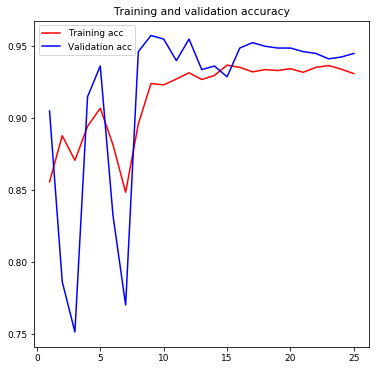

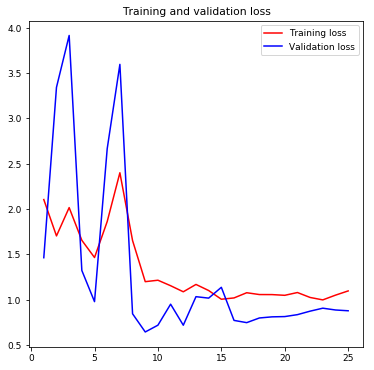

In [13]:
# 绘制 acc 和 loss 指标

plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [14]:
# 导入训练过程中 val_acc 最高 (可以认为效果最好) 的模型

from keras.models import load_model
best_model = load_model('trained_models/08-0.96.h5')

In [15]:
# 测试集的图片生成器

datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
        'data/test',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.


In [16]:
# 测试集也同样需要提取特征值

test_features, test_labels = extract_features(nb_test_samples, test_generator)
test_features = np.reshape(test_features, (nb_test_samples, flat_dim))

In [17]:
# 测试集效果 [loss, acc]

scores = best_model.evaluate(
    test_features,
    test_labels)
scores

128/200 [==================>...........] - ETA: 0s

[0.48002871740484238, 0.96999999999999997]

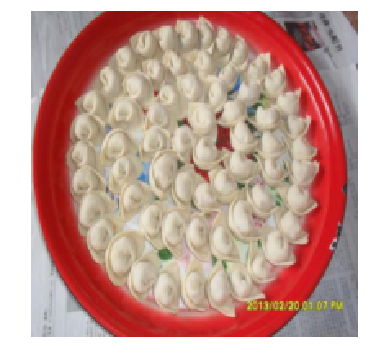

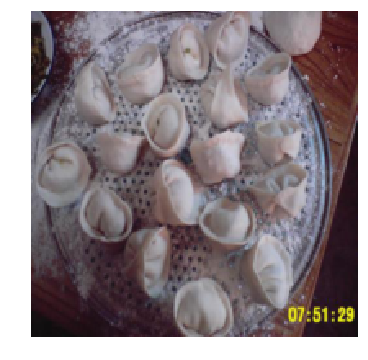

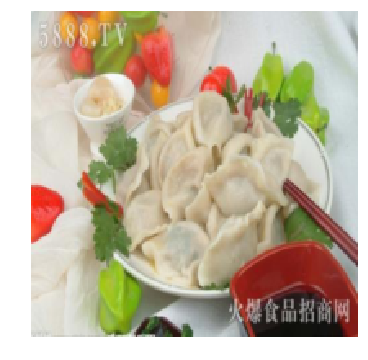

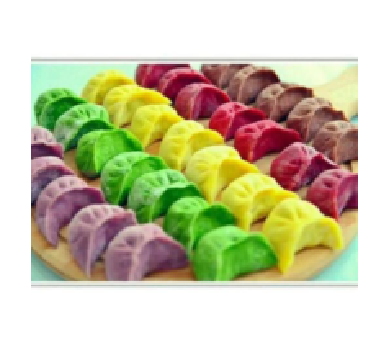

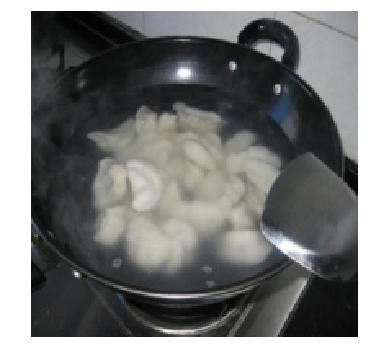

jiaozi acc: 0.95


In [18]:
# 对于新图片的预测, 使用 load_img -> imresize -> rescale -> reshape (增加一个维度) 的方式处理

total0 = 0.
e0cnt = 0.
for fn in os.listdir('data/test/jiaozi/'):
    img = load_img('data/test/jiaozi/' + fn)
    img = imresize(img, size=(img_height, img_width))
    test_x = img_to_array(img).reshape(img_height, img_width, 3)
    test_x = test_x / 255.
    test_x = test_x.reshape((1,) + test_x.shape)
    test_feature = base_model.predict(test_x)
    test_feature = test_feature.reshape((1, 7*7*2048))
    predicted = best_model.predict(test_feature)[0][0]
    if predicted > 0.5:
        e0cnt += 1
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    total0 += 1
print "jiaozi acc: {:.2f}".format(1-e0cnt/total0)

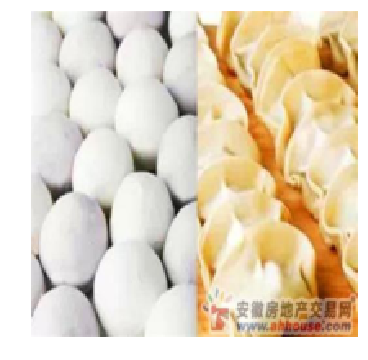

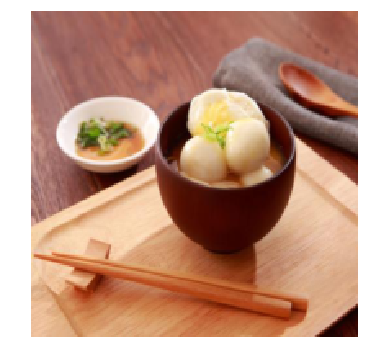

tangyuan acc: 0.98


In [19]:
total1 = 0.
e1cnt = 0.
for fn in os.listdir('data/test/tangyuan/'):
    img = load_img('data/test/tangyuan/' + fn)
    img = imresize(img, size=(img_height, img_width))
    test_x = img_to_array(img).reshape(img_height, img_width, 3)
    test_x = test_x / 255.
    test_x = test_x.reshape((1,) + test_x.shape)
    test_feature = base_model.predict(test_x)
    test_feature = test_feature.reshape((1, 7*7*2048))
    predicted = best_model.predict(test_feature)[0][0]
    if predicted < 0.5:
        e1cnt += 1
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    total1 += 1
print "tangyuan acc: {:.2f}".format(1-e1cnt/total1)